# Классификатор комментариев

Интернет-магазин «###» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В внашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

**Этапы выполнения проекта**

1. Загрузка и подготовка данных.
2. Обучение разных моделей. 
3. Формулировка выводов.


**Описание данных**

Данные находятся в файле `###.csv`. Столбец `text` в нём содержит текст комментария, а `toxic` — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-0">Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-0.1">Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-1">Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1">Вывод</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2">Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-3">Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm.notebook import tqdm
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)

In [2]:
try:
    df = pd.read_csv('/datasets/###.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/###.csv')

In [3]:
def check(data):
    data.info()
    display(data.head())
    display(data.describe())
    print(f'Количество пропусков: {data.isna().sum()}')
    print(f'Количество дубликатов: {data.duplicated().sum()}')
    print("\nРаспределение классов:\n", data['toxic'].value_counts())

In [4]:
check(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


Количество пропусков: Unnamed: 0    0
text          0
toxic         0
dtype: int64
Количество дубликатов: 0

Распределение классов:
 0    143106
1     16186
Name: toxic, dtype: int64


- **Количество записей:** 159,292, что является достаточно большим объемом данных для обучения модели машинного обучения.
- **Структура данных:** В DataFrame три столбца:
  - **Unnamed: 0:** Это, скорее всего, индекс, созданный при сохранении данных из CSV. Этот столбец не несет полезной информации для модели.
  - **text:** Это тексты комментариев, в них присутствуют спец.символы и числы. Очистим их с помощью регулярных выражений и лемматизируем.
  - **toxic:** Это целевая переменная (0 или 1), где 0 — не токсичный комментарий, а 1 — токсичный.
- Все столбцы содержат данные без пропусков
- Не найдено дубликатов
- Среднее значение для столбца `toxic` составляет около 0.10, что указывает на то, что примерно 10% комментариев являются токсичными. Это говорит о наличии классового дисбаланса, где не токсичные комментарии значительно преобладают.

Визуализируем распределение целевого признака.

(-1.25, 1.25, -1.25, 1.25)

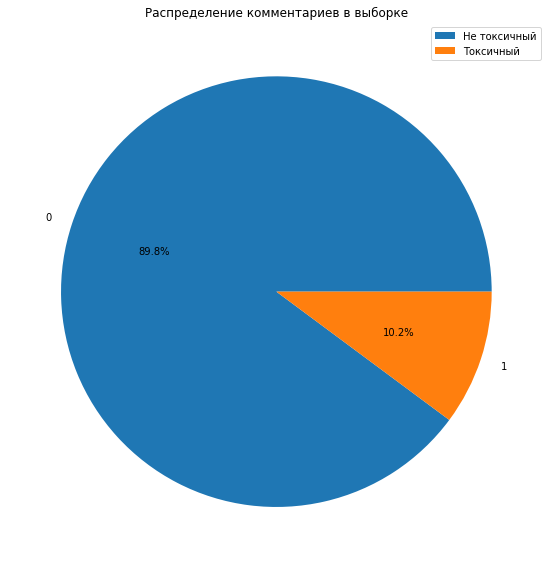

In [5]:
df.toxic.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10,8))
plt.legend(['Не токсичный','Токсичный'])
plt.title('Распределение комментариев в выборке')
plt.tight_layout()
plt.axis('off')

Проведем предобработку текста - удалим из текстов символы и числа, и приведем к нижнему регистру, удалим из текстов стоп-слова (слова, не несущие значения), лемматизируем тексты (приведем словоформы к первоначальной форме - лемме).

In [6]:
# Удаление лишнего столбца-индекса
df = df.drop('Unnamed: 0', axis=1)

In [8]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def clean_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление спецсимволов и цифр
    text = re.sub(r"[^a-zA-Z']", " ", text)
    # Удаление лишних пробелов
    text = re.sub(r"\s+", " ", text).strip()
    
    # Обработка текста с помощью spaCy
    doc = nlp(text)
    # Лемматизация и удаление стоп-слов
    words = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(words)

In [9]:
tqdm.pandas()
df['cleaned_text'] = df['text'].progress_apply(clean_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

Посмотрим получившийся результат.

In [10]:
df.head(10)

,text,toxic,cleaned_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation edit username hardcore metallica fan revert vandalism closure gas vote new york doll fac remove template talk page retire
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d'aww match background colour seemingly stuck thank talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man try edit war guy constantly remove relevant information talk edit instead talk page care formatting actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,real suggestion improvement wonder section statistic later subsection type accident think reference need tidy exact format ie date format etc later preference format style reference want let know appear backlog article review guess delay reviewer turn list relevant form eg wikipedia good article nomination transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,sir hero chance remember page
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0,congratulation use tool talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss work
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0,vandalism matt shirvington article revert ban
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0,sorry word ' nonsense ' offensive intend write article wow jump vandalism merely request encyclopedic use school reference selective breeding page stub point ' animal breeding ' short messy article give info expertise eugenic
9,alignment on this subject and which are contrary to those of DuLithgow,0,alignment subject contrary dulithgow


### Вывод

В ходе подготовки данных были выполнены следующие этапы:

1. Загруженны необходимые библиотеки и сами данные:
    - **Количество записей:** 159,292, что является достаточно большим объемом данных для обучения модели машинного обучения.
    - **Структура данных:** В DataFrame три столбца:
      - **Unnamed: 0:** Это, скорее всего, индекс, созданный при сохранении данных из CSV. Этот столбец не несет полезной информации для модели.
      - **text:** Это тексты комментариев, в них присутствуют спец.символы и числы. Очистим их с помощью регулярных выражений и лемматизируем.
      - **toxic:** Это целевая переменная (0 или 1), где 0 — не токсичный комментарий, а 1 — токсичный.
    - Все столбцы содержат данные без пропусков
    - Не найдено дубликатов
    - Среднее значение для столбца `toxic` составляет около 0.10, что указывает на то, что примерно 10% комментариев являются токсичными. Это говорит о наличии классового дисбаланса, где не токсичные комментарии значительно преобладают.
2. Удален столбец-индекс `Unnamed: 0`;
3. Текст очищен от символов и чисел;
4. Исследован баланс классов;
5. Текст лемматизирован и очищен от стоп-слов.

## Обучение

Разделим данные на тренировочную и тестовую выборки.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['toxic'],
                                                    test_size=0.1, random_state=42, stratify=df['toxic'])

In [12]:
print('Размер обучающего набора:', X_train.shape, y_train.shape)
print('Размер тестового набора:', X_test.shape, y_test.shape)

Размер обучающего набора: (143362,) (143362,)
Размер тестового набора: (15930,) (15930,)


Обучим модели с подбором гиперпараметров и векторизацией.

In [17]:
def training(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),  
        ('model', model)
    ])
    grid = GridSearchCV(pipeline, param_grid=params, scoring='f1', cv=5, n_jobs=-1, verbose=False)
    grid.fit(X_train, y_train)  

    print(f"Лучший F1 для {model.__class__.__name__}: {grid.best_score_:.4f}")
    print('Лучшие параметры:', grid.best_params_)
    return {
        'model': model.__class__.__name__,
        'F1': grid.best_score_,
        'best_params': grid.best_params_,
        'grid': grid
    }

In [18]:
lr = training(LogisticRegression(), {"model__C":[0.1, 1.0, 10.0], "model__solver": ["saga"]})

Лучший F1 для LogisticRegression: 0.7761
Лучшие параметры: {'model__C': 10.0, 'model__solver': 'saga'}


In [19]:
dtc = training(DecisionTreeClassifier(), {'model__criterion':['entropy'],
                                          'model__max_depth':[2, 100]})

Лучший F1 для DecisionTreeClassifier: 0.7049
Лучшие параметры: {'model__criterion': 'entropy', 'model__max_depth': 100}


In [20]:
scv = training(LinearSVC(max_iter=1000), {"model__C": [0.1, 1.0, 10.0], "model__dual": [False]})

Лучший F1 для LinearSVC: 0.7804
Лучшие параметры: {'model__C': 1.0, 'model__dual': False}


In [21]:
result = []
result.append(lr)
result.append(dtc)
result.append(scv)

In [22]:
mod_result = pd.DataFrame(result)[['model', 'F1', 'best_params']]

mod_result

,model,F1,best_params
0,LogisticRegression,0.776082,"{'model__C': 10.0, 'model__solver': 'saga'}"
1,DecisionTreeClassifier,0.704889,"{'model__criterion': 'entropy', 'model__max_depth': 100}"
2,LinearSVC,0.780427,"{'model__C': 1.0, 'model__dual': False}"


In [24]:
print(f"Тестовый F1 для LinearSVC: {f1_score(y_test, scv['grid'].predict(X_test)):.4f}")

Тестовый F1 для LinearSVC: 0.7887


### Вывод

В ходе обучения данных были выполнены следующие этапы:
1. Формирование обучающей и тестовой выборок.
2. Векторизация обучающей и тестовой выборок.
3. Обучение моделей и выбор лучшей из них на кросс-валидации.
4. Модель `LinearSVC` с гиперпараметрами `{'model__C': 1.0, 'model__dual': False}` показала лучший целевой показатель `F1` равный `0.780427` и удовлетворяющий требованию проекта.
5. Тестовый `F1` для `LinearSVC` составил `0.7887`.

## Выводы

В ходе подготовки данных были выполнены следующие этапы:

1. Загруженны необходимые библиотеки и сами данные:
    - **Количество записей:** 159,292, что является достаточно большим объемом данных для обучения модели машинного обучения.
    - **Структура данных:** В DataFrame три столбца:
      - **Unnamed: 0:** Это, скорее всего, индекс, созданный при сохранении данных из CSV. Этот столбец не несет полезной информации для модели.
      - **text:** Это тексты комментариев, в них присутствуют спец.символы и числы. Очистим их с помощью регулярных выражений и лемматизируем.
      - **toxic:** Это целевая переменная (0 или 1), где 0 — не токсичный комментарий, а 1 — токсичный.
    - Все столбцы содержат данные без пропусков
    - Не найдено дубликатов
    - Среднее значение для столбца `toxic` составляет около 0.10, что указывает на то, что примерно 10% комментариев являются токсичными. Это говорит о наличии классового дисбаланса, где не токсичные комментарии значительно преобладают.
2. Удален столбец-индекс `Unnamed: 0`;
3. Текст очищен от символов и чисел;
4. Исследован баланс классов;
5. Текст лемматизирован и очищен от стоп-слов.

В ходе обучения данных были выполнены следующие этапы:
1. Формирование обучающей и тестовой выборок.
2. Векторизация обучающей и тестовой выборок.
3. Обучение моделей и выбор лучшей из них на кросс-валидации.
4. Модель `LinearSVC` с гиперпараметрами `{'model__C': 1.0, 'model__dual': False}` показала лучший целевой показатель `F1` равный `0.774425598334677` и удовлетворяющий требованию проекта.
5. Тестовый `F1` для `LinearSVC` составил `0.78259874069834`.